<a href="https://colab.research.google.com/github/youzhanghe123/Using-DistilBERT-to-make-binary-sentiment-classification/blob/main/distilbert_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
import os


In [2]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train = pd.read_csv('/content/drive/MyDrive/DistilBert/imdb/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DistilBert/imdb/test.csv')
val = pd.read_csv('/content/drive/MyDrive/DistilBert/imdb/val.csv')

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True, #adds the [CLS] and [SEP] tokens
            return_token_type_ids=False, #DistilBERT does not use token type embeddings (as BERT does for sentence pairs)
            padding="max_length",
            truncation=True,
            max_length=256,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

train_dataset = SentimentDataset(train["text"], train["label"])
test_dataset = SentimentDataset(test["text"], test["label"])
val_dataset = SentimentDataset(val["text"], val["label"])

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [9]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
num_epochs = 7

train_loss=[]
val_loss=[]

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # for the training dataset
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    train_loss.append(average_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")
    # for the valuation dataset
    model.eval()
    total_val_loss = 0
    for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()

    val_average_loss = total_val_loss / len(val_loader)
    val_loss.append(val_average_loss)


Epoch 1/7: 100%|██████████| 625/625 [09:00<00:00,  1.16it/s]


Epoch 1/7, Loss: 0.2972


Epoch 2/7: 100%|██████████| 625/625 [09:08<00:00,  1.14it/s]


Epoch 2/7, Loss: 0.1603


Epoch 3/7: 100%|██████████| 625/625 [09:19<00:00,  1.12it/s]


Epoch 3/7, Loss: 0.0801


Epoch 4/7: 100%|██████████| 625/625 [08:59<00:00,  1.16it/s]


Epoch 4/7, Loss: 0.0430


Epoch 5/7: 100%|██████████| 625/625 [09:00<00:00,  1.16it/s]


Epoch 5/7, Loss: 0.0312


Epoch 6/7: 100%|██████████| 625/625 [09:01<00:00,  1.15it/s]


Epoch 6/7, Loss: 0.0221


Epoch 7/7: 100%|██████████| 625/625 [08:59<00:00,  1.16it/s]


Epoch 7/7, Loss: 0.0253


Epoch 7/7: 100%|██████████| 157/157 [01:08<00:00,  2.30it/s]


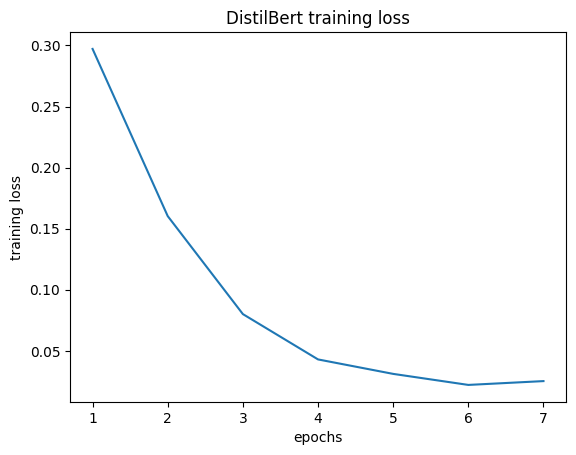

In [11]:
import seaborn as sns


# Plot the line using Seaborn
sns.lineplot(x=[i+1 for i in range(num_epochs)], y=train_loss)

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('DistilBert training loss')

# Show the plot
plt.show()


In [13]:
# Evaluate the model
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating: 100%|██████████| 782/782 [05:41<00:00,  2.29it/s]

Test Accuracy: 0.8857


In [16]:
# Evaluate the model
model.eval()

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"TRAIN Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 625/625 [05:03<00:00,  2.06it/s]

TRAIN Accuracy: 0.9960


In [17]:
# Evaluate the model
model.eval()

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"validation Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]

validation Accuracy: 0.9756
